In [1]:
# For interactive plots, comment the next line
%pylab inline
# For interactive plots, uncomment the next line
# %pylab ipympl
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# Introduction

This notebook demonstrates how to create a basic application in PODPAC, and run it in the cloud.
It uses SMAP data and TWI data to create a TOPMODEL-based downscaling algorithm.

## Setup

Make sure you have PODPAC installed with the **datatype** optional dependencies:

```
$ pip install podpac[datatype]
```

## Caveat

This notebook relies on data from a private WCS server and will not run for most users.

The following is meant to serve as inspiration for creating new applications.

# PODPAC Soil Moisture Downscaling Application

# Create nodes to access basic data sources

In [2]:
import podpac
import podpac.datalib

# Enable unsafe evaluation of arbitrary Python code, used by Arithmetic and Generic nodes. 
podpac.settings.set_unsafe_eval(True)

# Set the WCS_URL and TWI settings
# podpac.settings['WCS_URL'] = 'URL TO WCS SERVER'
# podpac.settings['TWI'] = 'TWI LAYER NAME ON WCS SERVER'

In [3]:
# Create podpac nodes for accessing data via OpenDAP from the 
# National Snow and Ice Datacenter (NSIDC)
smap = podpac.datalib.smap.SMAP(interpolation='bilinear')
wilt = podpac.datalib.smap.SMAPWilt(interpolation='bilinear')
porosity = podpac.datalib.smap.SMAPPorosity(interpolation='bilinear')

# Create podpac node to access topographic wetness index (TWI) via 
# WCS from a private server
twi = podpac.data.WCS(source=podpac.settings['WCS_URL'], 
                      layer_name=podpac.settings['TWI'],
                      interpolation='nearest', cache_type='disk')

# Create node derived from base TWI

In [4]:
# Reproject high resolution TWI onto low resolution SMAP grid
twi_bar = podpac.data.ReprojectedSource(source=twi,
                                        reprojected_coordinates=smap.shared_coordinates,       
                                        interpolation='bilinear', cache_type='disk')

INFO:pydap:Fetching URL: https://n5eil02u.ecs.nsidc.org/opendap/SMAP/SPL4SMAU.004/2015.03.31/SMAP_L4_SM_aup_20150331T030000_Vv4030_001.h5.dods?cell_lon[0:1:1623][0:1:3855]
INFO:pydap:Fetching URL: https://n5eil02u.ecs.nsidc.org/opendap/SMAP/SPL4SMAU.004/2015.03.31/SMAP_L4_SM_aup_20150331T030000_Vv4030_001.h5.dods?cell_lat[0:1:1623][0:1:3855]


# Create downscaling algorithm using all previously-created nodes
$\theta = \Theta_{SMAP} + \frac{\rho - \Theta_w}{\kappa}(\lambda - \bar \lambda)$

In [5]:
# Create downscaling algorithm
downscaled_sm = podpac.algorithm.Arithmetic(
    A=smap, B=twi, C=twi_bar, D=porosity, E=wilt, 
    eqn='A + (D - E) / 13.0 * (B - C) ')

# Create coordinates

In [6]:
# Create arbitrary set of coordinates
coordinates = podpac.Coordinates([podpac.clinspace(41, 40.9, 916), 
                                  podpac.clinspace(-77,-76.9, 916),  
                                  '2017-09-03T12:00:00'],
                                  dims=['lat', 'lon', 'time'])

# Evaluate node on local workstation

In [7]:
# Evaluate locally
downscaled_soil_moisture = downscaled_sm.eval(coordinates)

INFO:pydap:Fetching URL: https://n5eil02u.ecs.nsidc.org/opendap/SMAP/SPL4SMAU.004/2017.09.03/SMAP_L4_SM_aup_20170903T120000_Vv4030_001.h5.dods?Analysis_Data_sm_surface_analysis[278:1:280][1102:1:1104]
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:pydap:Fetching URL: https://n5eil02u.ecs.nsidc.org/opendap/SMAP/SPL4SMLM.004/2015.03.31/SMAP_L4_SM_lmc_00000000T000000_Vv4030_001.h5.dods?cell_lon[0:1:1623][0:1:3855]
INFO:pydap:Fetching URL: https://n5eil02u.ecs.nsidc.org/opendap/SMAP/SPL4SMLM.004/2015.03.31/SMAP_L4_SM_lmc_00000000T000000_Vv4030_001.h5.dods?cell_lat[0:1:1623][0:1:3855]
INFO:pydap:Fetching URL: https://n5eil02u.ecs.nsidc.org/opendap/SMAP/SPL4SMLM.004/2015.03.31/SMAP_L4_SM_lmc_00000000T000000_Vv4030_001.h5.dods?Land_Model_Constants_Data_clsm_poros[278:1:280][1102:1:1104]
INFO:pydap:Fetching URL: https://n5eil02u.ecs.nsidc.org/opendap/SMAP/SPL4SMLM.004/2015.03.31/SMAP_L4_SM_lmc_00000000T000000_Vv4030_001.h5.dods?cell_lon[0:1:1623][0:1:3855]
INFO:pydap:Fetching URL: ht

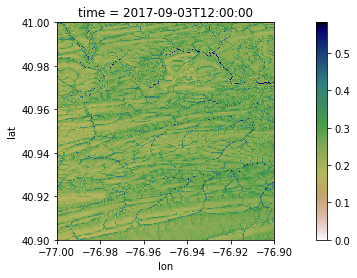

In [8]:
# Plot the results
downscaled_soil_moisture.plot(cmap='gist_earth_r', vmin=0)
axis('scaled')
pass